In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.spatial.transform import Rotation
import math
from scipy.stats import norm, zscore, multivariate_normal
import woti

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA

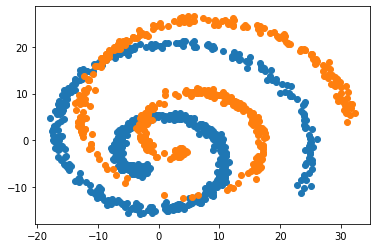

In [2]:
# Generating data

def generate_spiral(n, length=6.18, min_radius=1, sigma_hubs=1, sigma_jitter=1, hubs=3, sigma_translation=5):
    """ Creates random spirals. Warning, method is not very robust, and sometimes produces unusable datasets."""
    n_hubs = len(hubs)
    t = np.zeros((n,))
    pos = 0
    for h in range(n_hubs):
        if h < n_hubs - 1:
            n_points = int(np.random.normal(n/n_hubs, np.sqrt(n/n_hubs)))
        else:
            n_points = n - pos
        n_points = min(n - pos, n_points)
        if n_points <= 0:
            break
        t[pos:pos+n_points] = np.random.normal(hubs[h], sigma_hubs, (n_points,))
        pos += n_points
    
    t = t[(t > 0)*(t<length)]
    n = len(t)
    offset = np.random.normal(0, 1)
    X = np.array([t, np.cos(.5*(t+offset))*(t+min_radius), np.sin(.5*(t+offset))*(t+min_radius)]).T
    X += np.random.normal(0, sigma_jitter, (n,3))
    X += np.random.normal(0, sigma_translation, (3,))
    return X, t

# Generate
# xs, colors_s = generate_spiral(500, length=24, sigma_hubs=1, sigma_jitter=0.5, hubs=[0, 6, 10, 12, 18, 20, 22, 24])
# yt, colors_t = generate_spiral(1000, length=24, sigma_hubs=10, sigma_jitter=0.5, hubs=list(range(24)))

# Save
# np.savetxt("datasets/xs.csv", xs, delimiter=',')
# np.savetxt("datasets/yt.csv", yt, delimiter=',')
# np.savetxt("datasets/cs.csv", colors_s, delimiter=',')
# np.savetxt("datasets/ct.csv", colors_t, delimiter=',')

# Load
xs = np.loadtxt("datasets/xs.csv", delimiter=',')
yt = np.loadtxt("datasets/yt.csv", delimiter=',')
colors_s = np.loadtxt("datasets/cs.csv", delimiter=',')
colors_t = np.loadtxt("datasets/ct.csv", delimiter=',')

pca = PCA(n_components=2)
yt_pca = pca.fit_transform(yt)
xs_pca = pca.transform(xs)

plt.scatter(yt_pca[:,0], yt_pca[:,1])
plt.scatter(xs_pca[:,0], xs_pca[:,1])

# Optimal transport

In [3]:
w_weighted = woti.Woti(method='ot', scale=1e-1)
w_unweighted = woti.Woti(method='ot', weighted=False, scale=1e-1)

WOTi > Successfully initialized.
(Woti) ot based -- max_iter: 1000000 -- no entropy -- weighted, alpha_qp: 1.000000, scale: 0.100000
WOTi > Successfully initialized.
(Woti) ot based -- max_iter: 1000000 -- no entropy -- unweighted


In [4]:
xt_unweighted = w_unweighted.fit_transform(xs, yt) # Equal weights
xt_weighted = w_weighted.fit_transform(xs, yt) # Density correction
xt_pca = pca.transform(xt_weighted)
xt_nd_pca = pca.transform(xt_unweighted)

WOTi > Computing optimal transport plan...
WOTi > Computing optimal transport plan...
WOTi > WOTi fitted.
WOTi > Projecting dataset...
WOTi > Computing source distribution weights...
WOTi > Computing reference distribution weights...
WOTi > Computing optimal transport plan...
WOTi > Computing optimal transport plan...
WOTi > WOTi fitted.
WOTi > Projecting dataset...


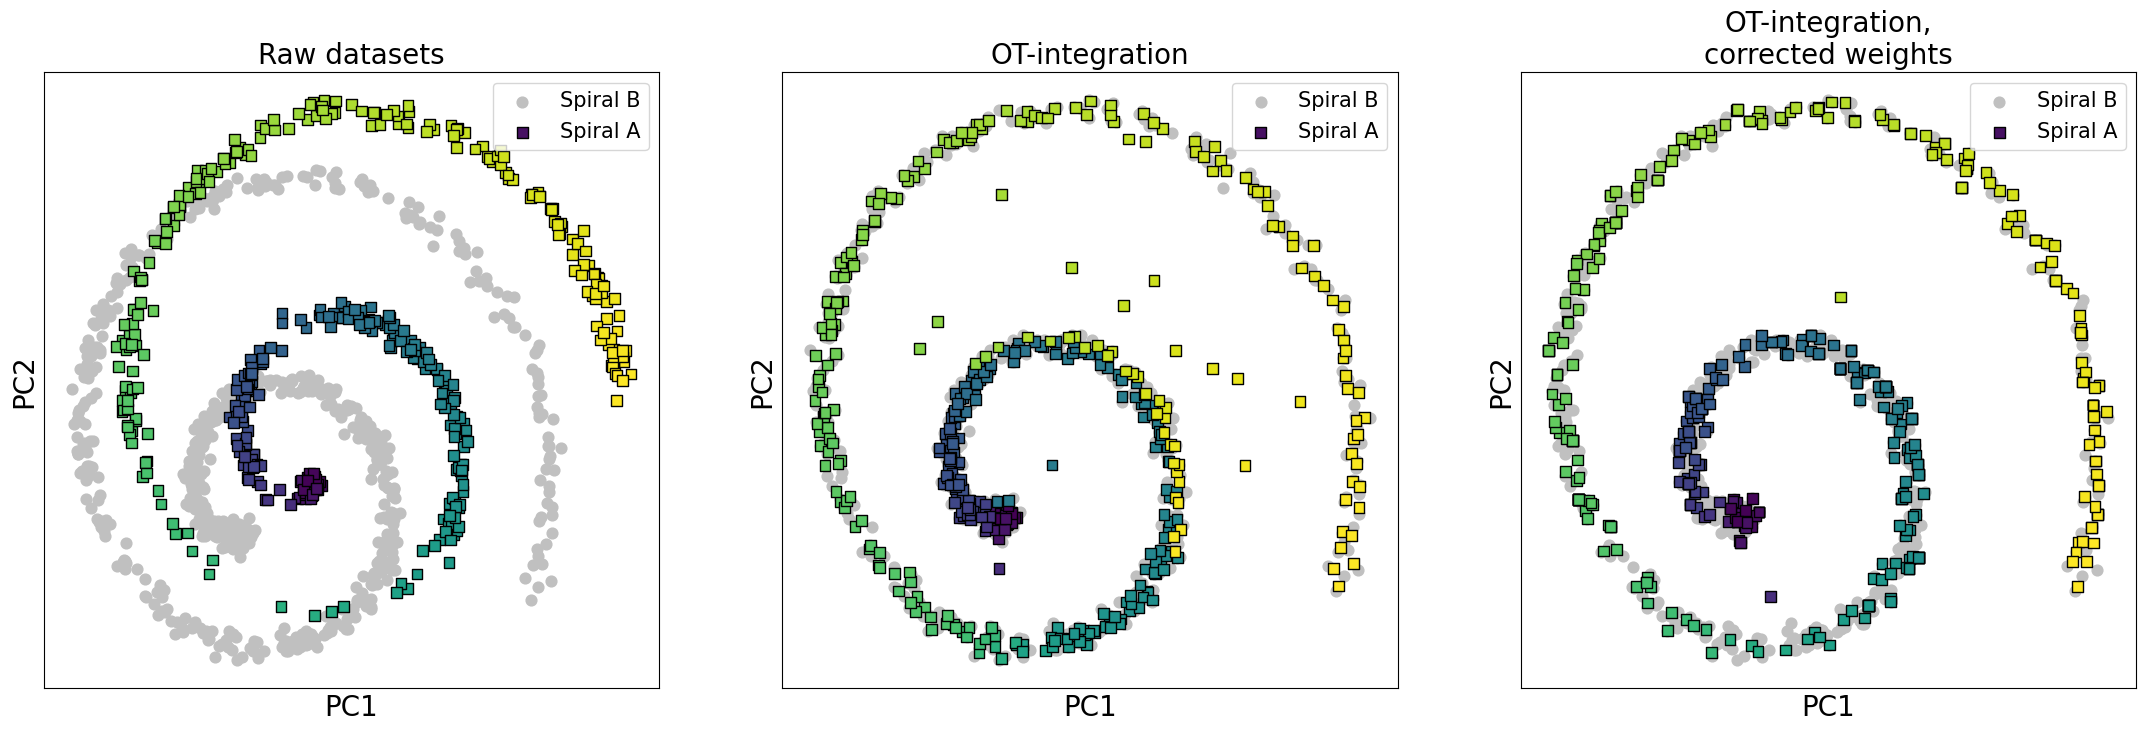

In [5]:
# Optimal transport

plt.style.use('default')

plt.figure(figsize=(27,8))

plt.subplot(1,3,1)
plt.scatter(*yt_pca.T, s=60, c='silver', label='Spiral B')
plt.scatter(*xs_pca.T, s=60, c=colors_s, cmap='viridis', ec='k', label='Spiral A', marker='s')
plt.xlabel("PC1", fontsize=20)
plt.ylabel("PC2", fontsize=20)
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=15)
plt.title('Raw datasets', fontsize=20)

plt.subplot(1,3,2)
plt.scatter(*yt_pca.T, s=60, c='silver', label='Spiral B')
plt.scatter(*xt_nd_pca.T, s=60, c=colors_s, cmap='viridis', ec='k', label='Spiral A', marker='s')
plt.xlabel("PC1", fontsize=20)
plt.ylabel("PC2", fontsize=20)
plt.xticks([]) 
plt.yticks([])
plt.legend(fontsize=15)
plt.title('OT-integration', fontsize=20)

plt.subplot(1,3,3)
plt.scatter(*yt_pca.T, s=60, c='silver', label='Spiral B')
plt.scatter(*xt_pca.T, s=60, c=colors_s, cmap='viridis', ec='k', label='Spiral A', marker='s')
plt.xlabel("PC1", fontsize=20)
plt.ylabel("PC2", fontsize=20)
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=15)
plt.title('OT-integration,\ncorrected weights', fontsize=20)
pass

In [6]:
colors_stu = w_unweighted.label_transfer(colors_t)
colors_stw = w_weighted.label_transfer(colors_t)

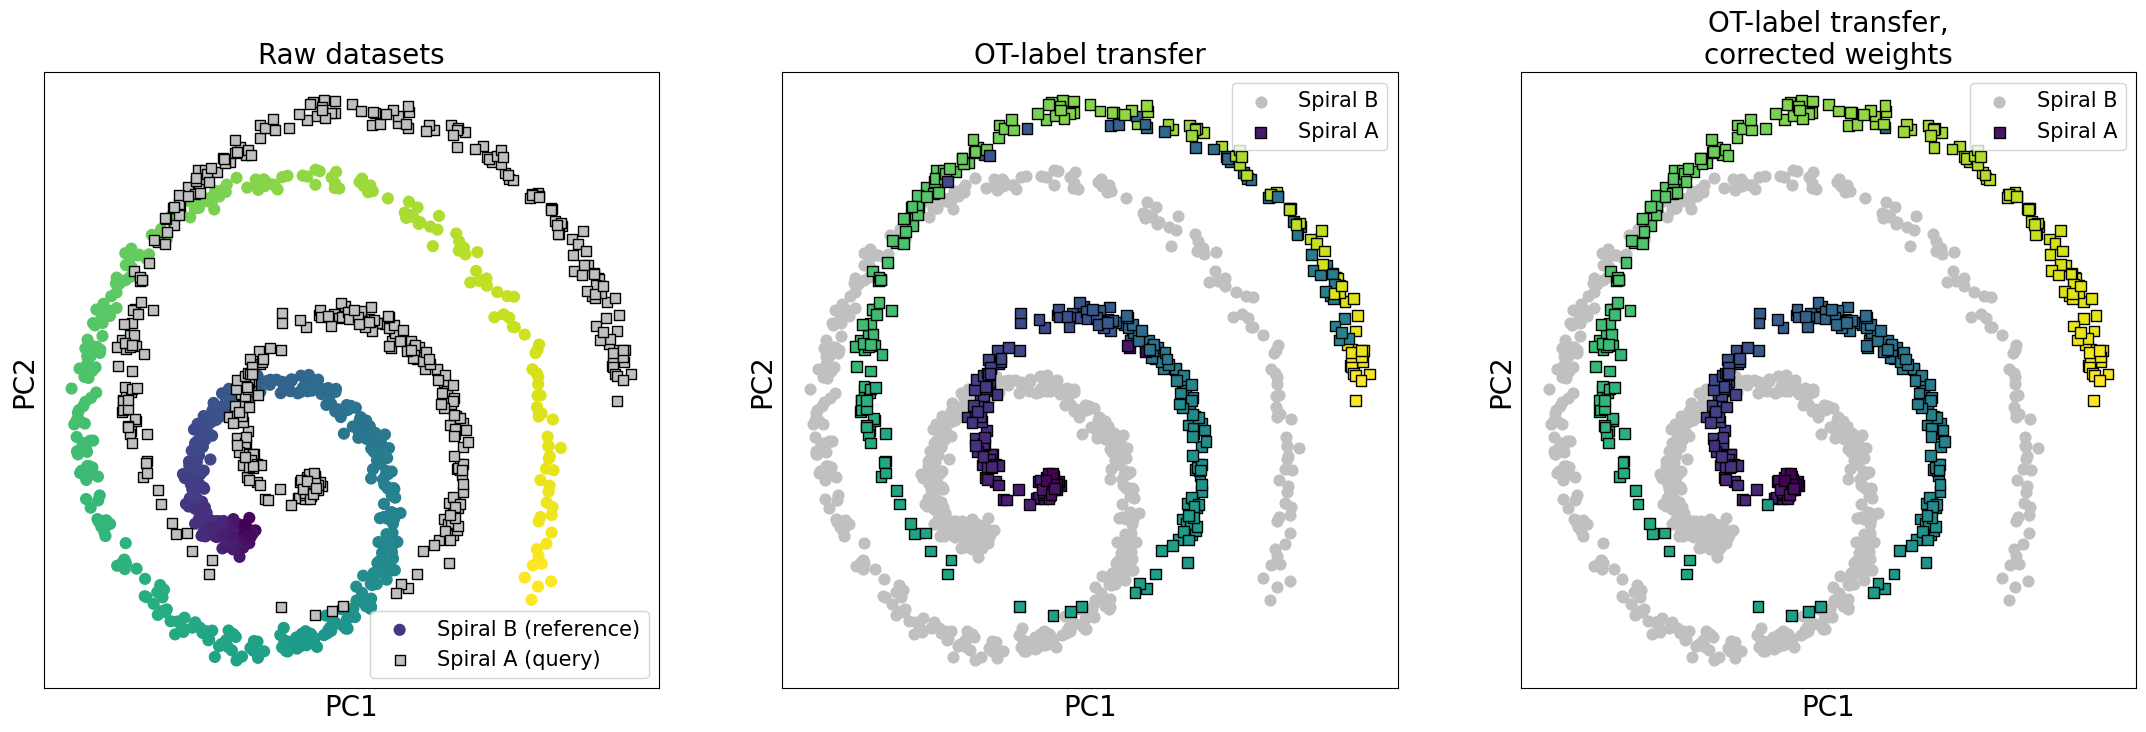

In [7]:
# Optimal transport

plt.style.use('default')

plt.figure(figsize=(27,8))

plt.subplot(1,3,1)
plt.scatter(*yt_pca.T, s=60, c=colors_t, label='Spiral B (reference)')
plt.scatter(*xs_pca.T, s=60, c='silver', cmap='viridis', ec='k', label='Spiral A (query)', marker='s')
plt.xlabel("PC1", fontsize=20)
plt.ylabel("PC2", fontsize=20)
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=15)
plt.title('Raw datasets', fontsize=20)

plt.subplot(1,3,2)
plt.scatter(*yt_pca.T, s=60, c='silver', label='Spiral B')
plt.scatter(*xs_pca.T, s=60, c=colors_stu, cmap='viridis', ec='k', label='Spiral A', marker='s')
plt.xlabel("PC1", fontsize=20)
plt.ylabel("PC2", fontsize=20)
plt.xticks([]) 
plt.yticks([])
plt.legend(fontsize=15)
plt.title('OT-label transfer', fontsize=20)

plt.subplot(1,3,3)
plt.scatter(*yt_pca.T, s=60, c='silver', label='Spiral B')
plt.scatter(*xs_pca.T, s=60, c=colors_stw, cmap='viridis', ec='k', label='Spiral A', marker='s')
plt.xlabel("PC1", fontsize=20)
plt.ylabel("PC2", fontsize=20)
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=15)
plt.title('OT-label transfer,\ncorrected weights', fontsize=20)
pass